In [1]:
import numpy as np 
import pandas as pd
import os

In [2]:
PATH = "/home/vishy/Desktop/Myfiles/Kaggle/RSNA_PE/"
train = pd.read_csv(PATH+"inputs/train.csv")
test = pd.read_csv(PATH+"inputs/test.csv")
sub = pd.read_csv(PATH+"inputs/sample_submission.csv")
print(train.shape, test.shape, sub.shape)

(1790594, 17) (146853, 3) (152703, 2)


In [3]:
train.head(5)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [4]:
train.groupby('StudyInstanceUID')['SeriesInstanceUID'].nunique().max(), test.groupby('StudyInstanceUID')['SeriesInstanceUID'].nunique().max()
# This shows that the Study and series ID has a 1-1 mapping

(1, 1)

In [5]:
np.intersect1d(train.StudyInstanceUID.unique(), test.StudyInstanceUID.unique())
# No repeated StudyInstanceUID between train and test

array([], dtype=object)

In [6]:
train_image_num_per_patient = train.groupby('StudyInstanceUID')['SOPInstanceUID'].nunique()
test_image_num_per_patient = test.groupby('StudyInstanceUID')['SOPInstanceUID'].nunique()
print(train_image_num_per_patient, test_image_num_per_patient)

StudyInstanceUID
0003b3d648eb    223
000f7f114264    239
00102474a2db    326
0038fd5f09f5    230
0045f113e031    257
               ... 
ffe5280cd21d    240
ffe7efaccbb9    250
fff1ef450040    272
fff9536823b1    388
fffda3f22362    169
Name: SOPInstanceUID, Length: 7279, dtype: int64 StudyInstanceUID
00268ff88746    236
00c53115a9fa    205
00e7015490cb    173
017d4bd72a02    239
0185602e0766    232
               ... 
fda6fb996297    269
fdbbd076dcdb    198
fde9ecc1c2b5    232
fe449a869d7a    239
ff62ec60c99b    206
Name: SOPInstanceUID, Length: 650, dtype: int64


In [7]:
train_image_num_per_patient.describe()

count    7279.000000
mean      245.994505
std        73.530745
min        63.000000
25%       212.000000
50%       234.000000
75%       256.000000
max      1083.000000
Name: SOPInstanceUID, dtype: float64

In [8]:
test_image_num_per_patient.describe()

count    650.000000
mean     225.927692
std       37.341088
min       87.000000
25%      207.000000
50%      229.000000
75%      247.750000
max      407.000000
Name: SOPInstanceUID, dtype: float64

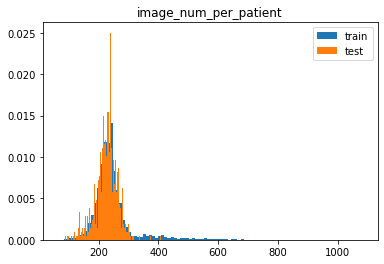

'\nAs we could see, the number of images per patient in train and test are pretty close, except some slight right shift in train set (comparing the 25%-50%-75% from the describe() method)\n\nFrom the above, it is better to also do stratified split based on the image number per patient to simulate train-test split\nWe will do validation splits based on\nPatient: Same patient should be in the same validation split\nNumber of image per patient: Distribution should be similar across all validation splits\n'

In [9]:
import matplotlib.pyplot as plt
plt.title('image_num_per_patient')
plt.hist(train_image_num_per_patient, bins=100, label='train', density=True)
plt.hist(test_image_num_per_patient, bins=100, label='test', density=True)
plt.legend()
plt.show()

"""
As we could see, the number of images per patient in train and test are pretty close, except some slight right shift in train set (comparing the 25%-50%-75% from the describe() method)

From the above, it is better to also do stratified split based on the image number per patient to simulate train-test split
We will do validation splits based on
Patient: Same patient should be in the same validation split
Number of image per patient: Distribution should be similar across all validation splits
"""

In [10]:
FOLD_NUM = 20
target_cols = [c for i, c in enumerate(train.columns) if i > 2]

In [11]:
# build summary of image num and target variables for each patient
train_per_patient_char = pd.DataFrame(index=train_image_num_per_patient.index, columns=['image_per_patient'], data=train_image_num_per_patient.values.copy())
for t in target_cols:
    train_per_patient_char[t] = train_per_patient_char.index.map(train.groupby('StudyInstanceUID')[t].mean())

train_per_patient_char.head(10)

# only pe_present_on_image is image level, that's why only it is the only patient-level value with floating number after averaging

,image_per_patient,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
StudyInstanceUID,,,,,,,,,,,,,,,
0003b3d648eb,223,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
000f7f114264,239,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
00102474a2db,326,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
0038fd5f09f5,230,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
0045f113e031,257,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
004a429fc727,218,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
004b06506f54,232,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
004f9a1605e7,239,0.188285,0,0,0,0,1,0,0,1,0,1,0,1,0
00511e94edec,208,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# make image_per_patient and pe_present_on_image into bins
bin_counts = [40] #, 20]
digitize_cols = ['image_per_patient'] #, 'pe_present_on_image']
non_digitize_cols = [c for c in train_per_patient_char.columns if c not in digitize_cols]

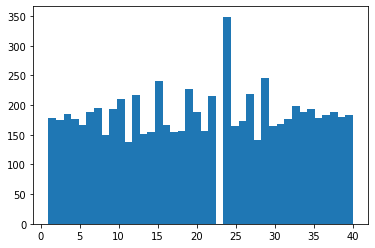

In [13]:
for i, c in enumerate(digitize_cols):
    bin_count = bin_counts[i]
    percentiles = np.percentile(train_per_patient_char[c], q=np.arange(bin_count)/bin_count*100.)
    #print(percentiles)
    #print(train_per_patient_char[c].value_counts())
    train_per_patient_char[c+'_digitize'] = np.digitize(train_per_patient_char[c], percentiles, right=False)
    #print(train_per_patient_char[c+'_digitize'].value_counts())
    plt.hist(train_per_patient_char[c+'_digitize'], bins=bin_count)
    plt.show()

In [14]:
train_per_patient_char['key'] = train_per_patient_char[digitize_cols[0]+'_digitize'].apply(str)
for c in digitize_cols[1:]:
    train_per_patient_char['key'] = train_per_patient_char['key']+'_'+train_per_patient_char[c+'_digitize'].apply(str)

train_per_patient_char['key'].value_counts()

24    349
29    245
15    240
19    228
27    218
12    217
22    216
10    211
33    199
7     195
9     194
35    193
38    189
6     188
34    188
20    188
3     185
40    184
37    183
39    180
1     178
36    178
4     177
32    177
2     175
26    174
31    168
16    166
5     166
30    164
25    164
21    157
18    156
14    155
17    154
13    151
8     149
28    142
11    138
Name: key, dtype: int64

In [15]:
from sklearn.model_selection import StratifiedKFold
folds = FOLD_NUM
kfolder = StratifiedKFold(n_splits=folds, shuffle=True, random_state=719)
val_indices = [val_indices for _, val_indices in kfolder.split(train_per_patient_char['key'], train_per_patient_char['key'])]

train_per_patient_char['fold'] = -1
for i, vi in enumerate(val_indices):
    patients = train_per_patient_char.index[vi]
    train_per_patient_char.loc[patients, 'fold'] = i
train_per_patient_char['fold'].value_counts()

17    364
15    364
4     364
8     364
12    364
16    364
1     364
5     364
9     364
13    364
0     364
2     364
6     364
10    364
14    364
18    364
3     364
7     364
11    364
19    363
Name: fold, dtype: int64

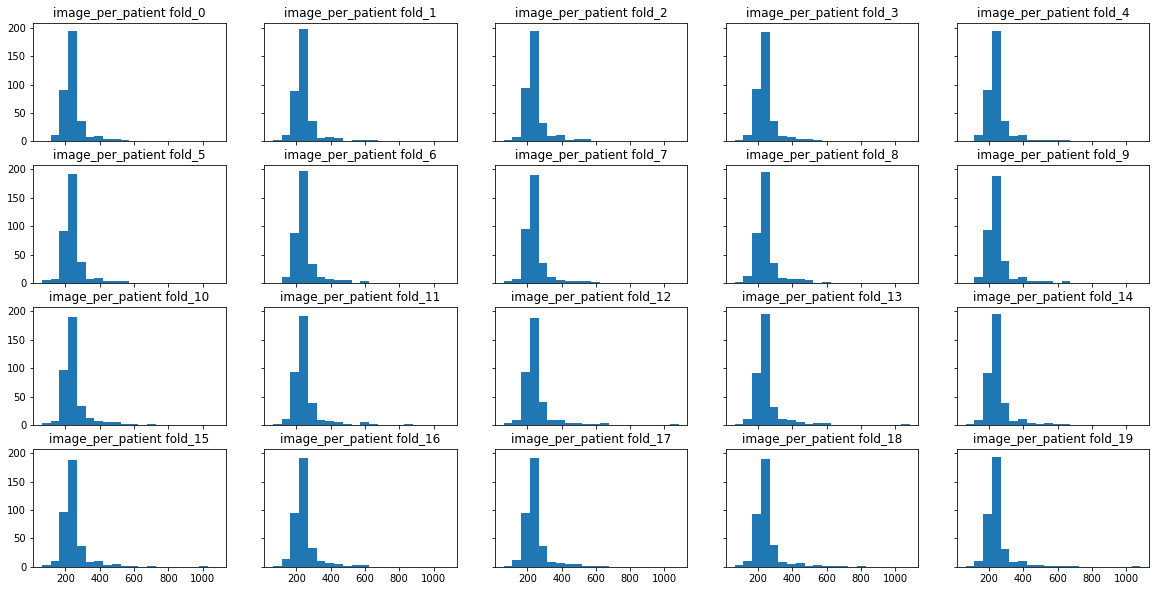

In [16]:
for col in digitize_cols:
    fig, axs = plt.subplots(nrows=4, ncols=int(np.floor(folds/4)), constrained_layout=False, sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    axs = axs.flat
    for i, vi in enumerate(val_indices):
        patients = train_per_patient_char.index[vi]
        axs[i].set_title(col+' fold_'+str(i))
        axs[i].hist(train_per_patient_char.loc[patients, col], bins=20, range=(train_per_patient_char[col].min(), train_per_patient_char[col].max()))
    plt.show()

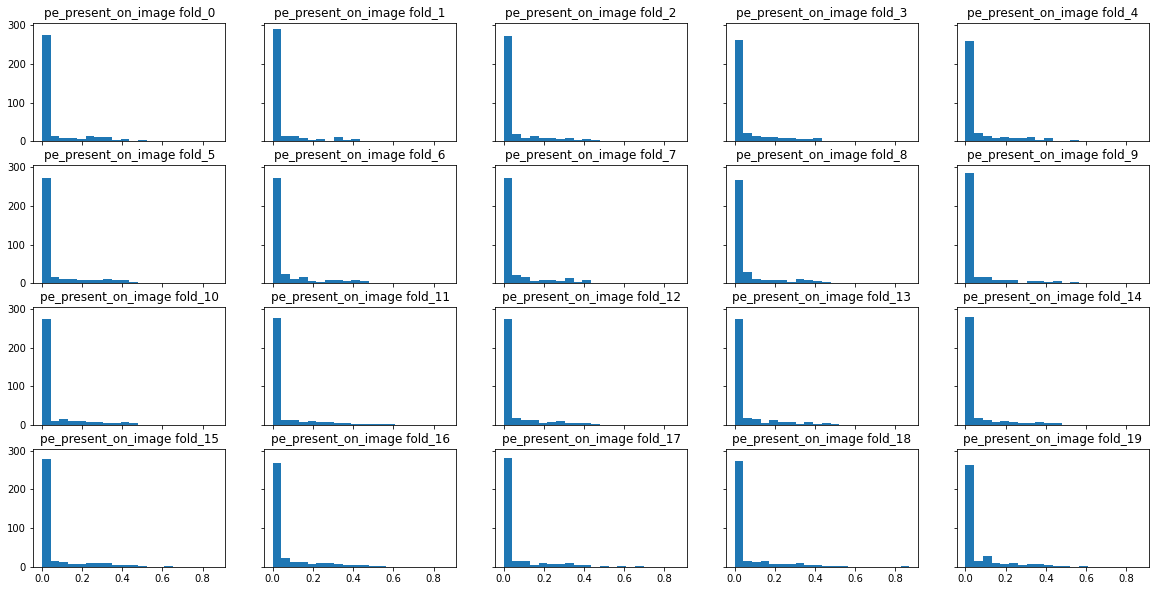

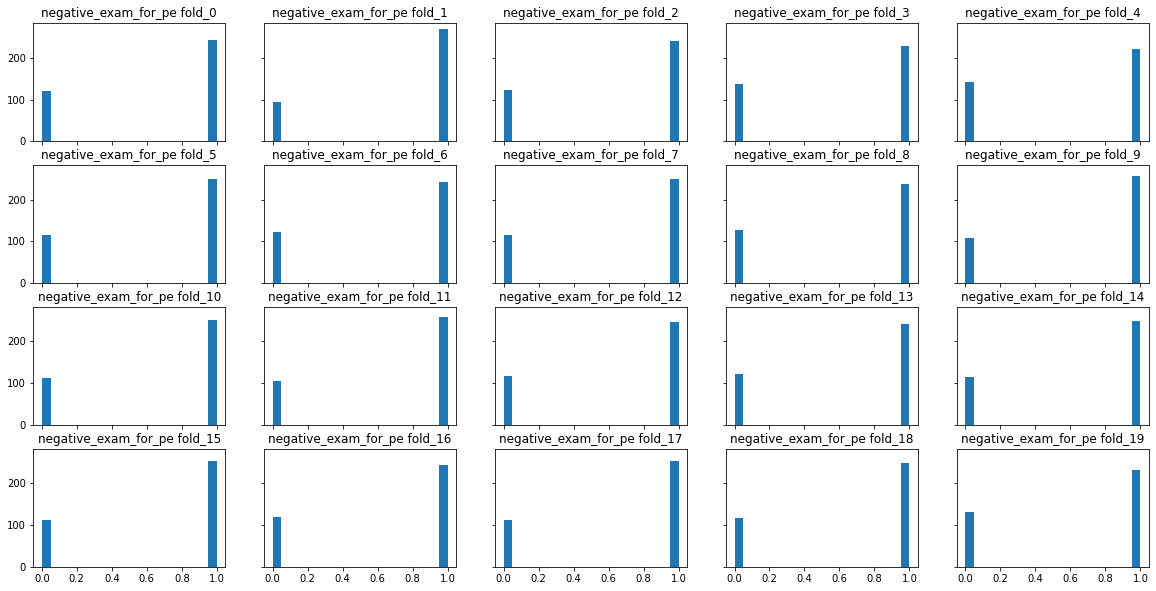

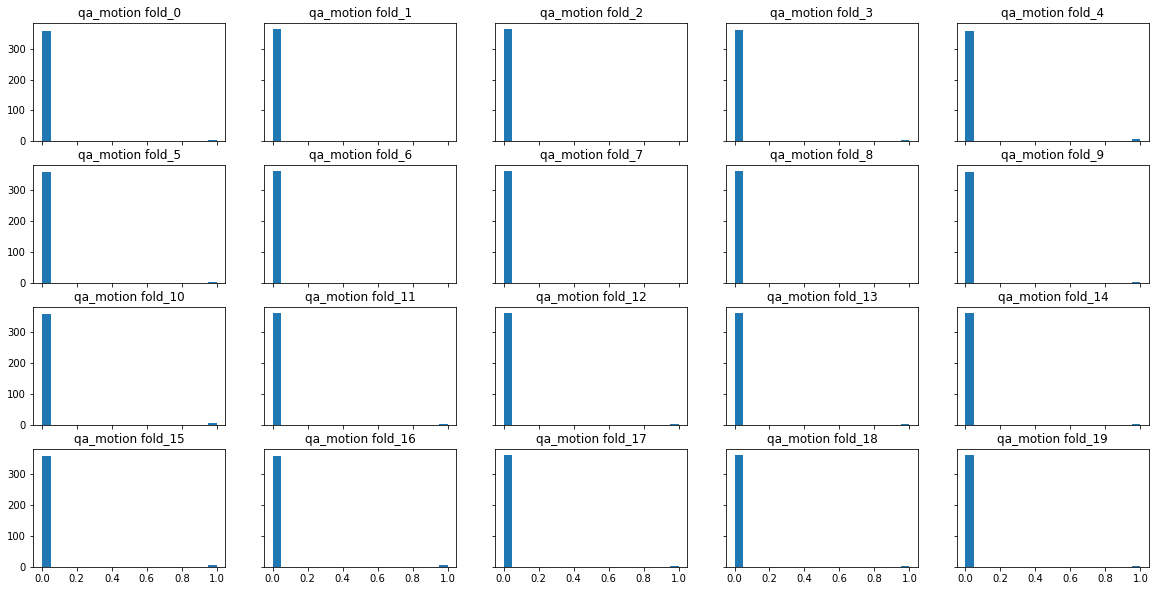

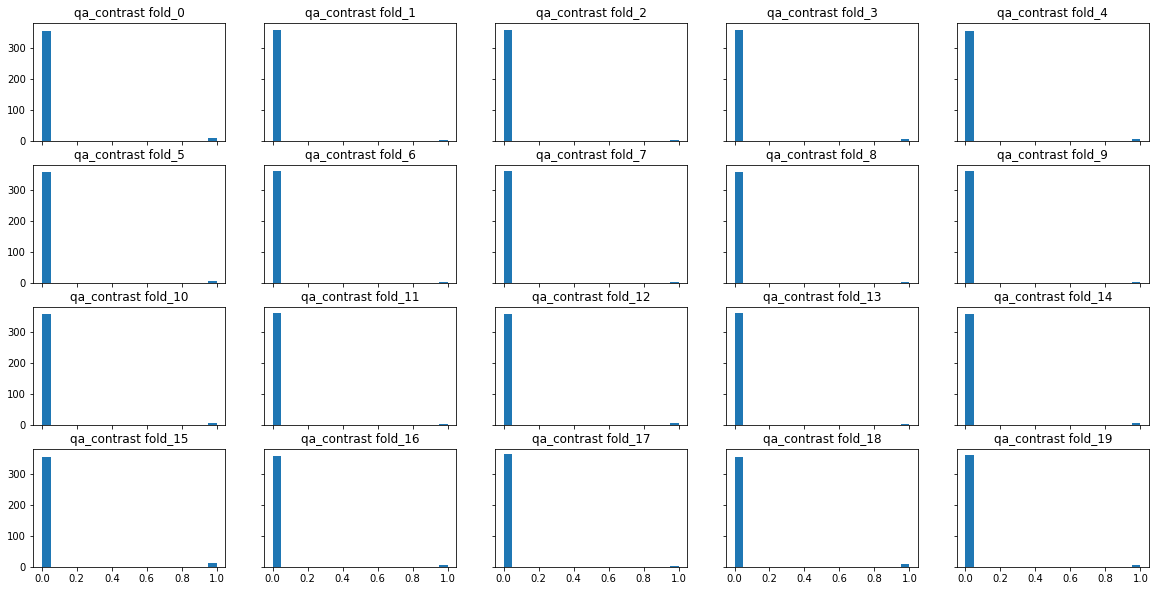

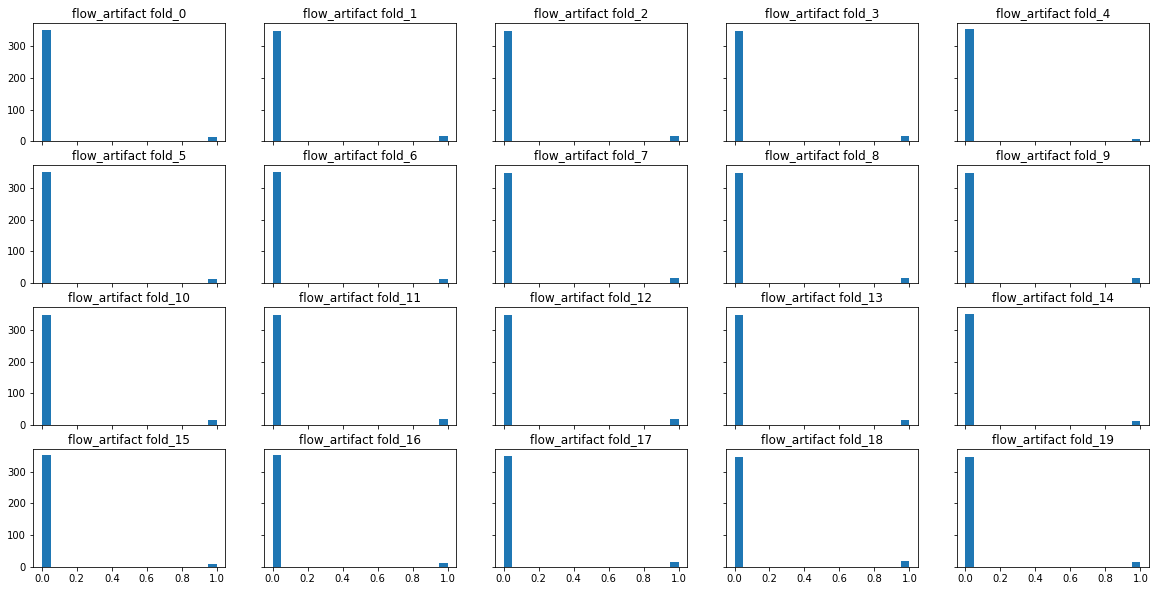

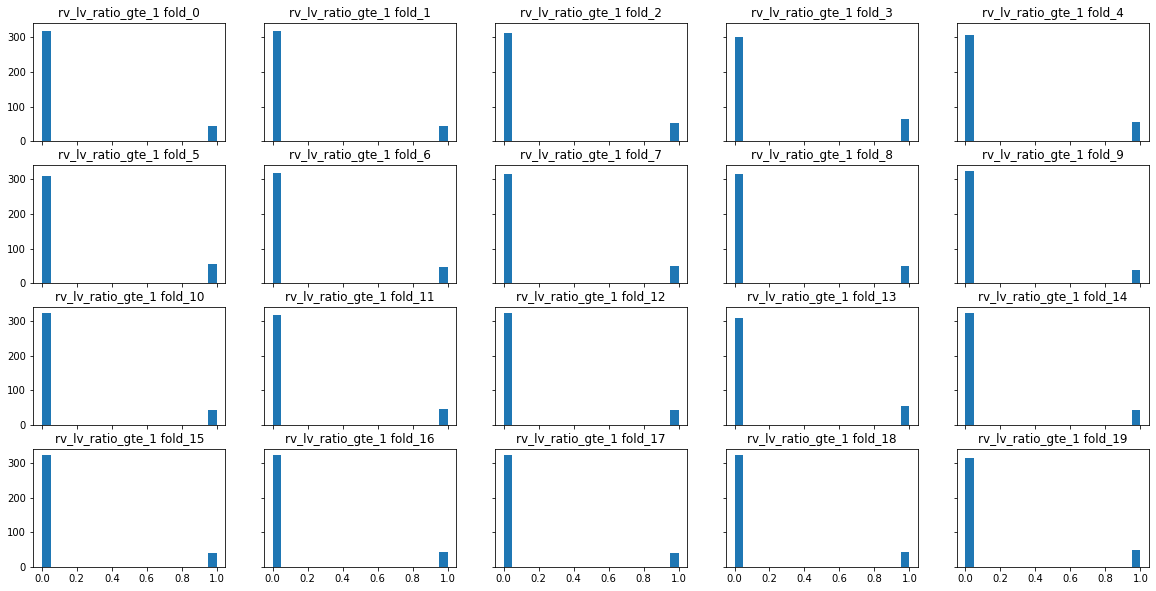

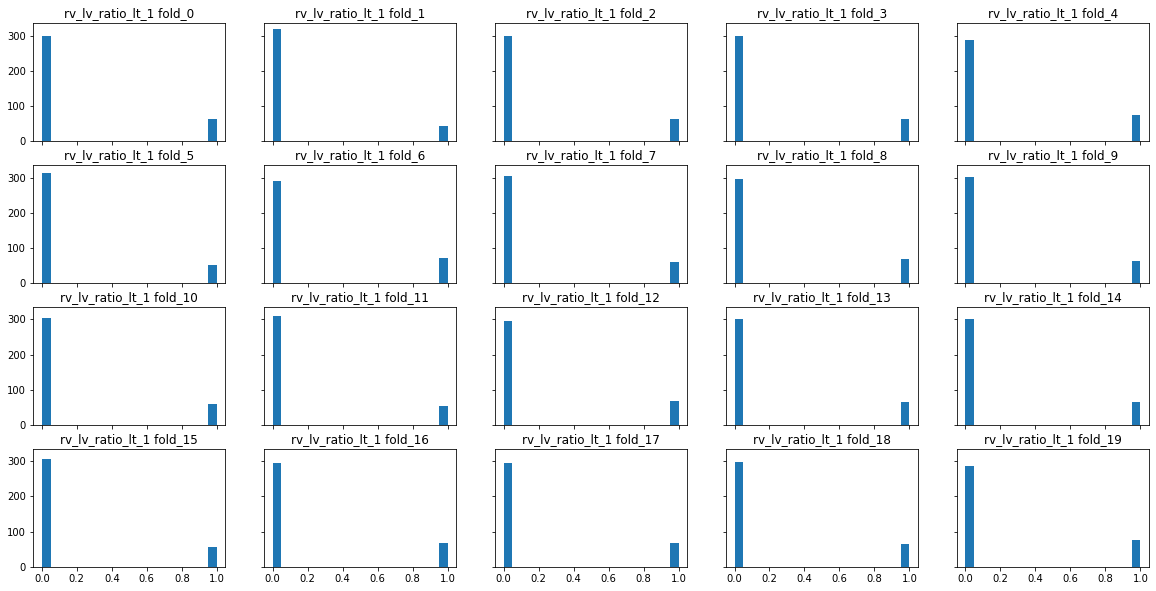

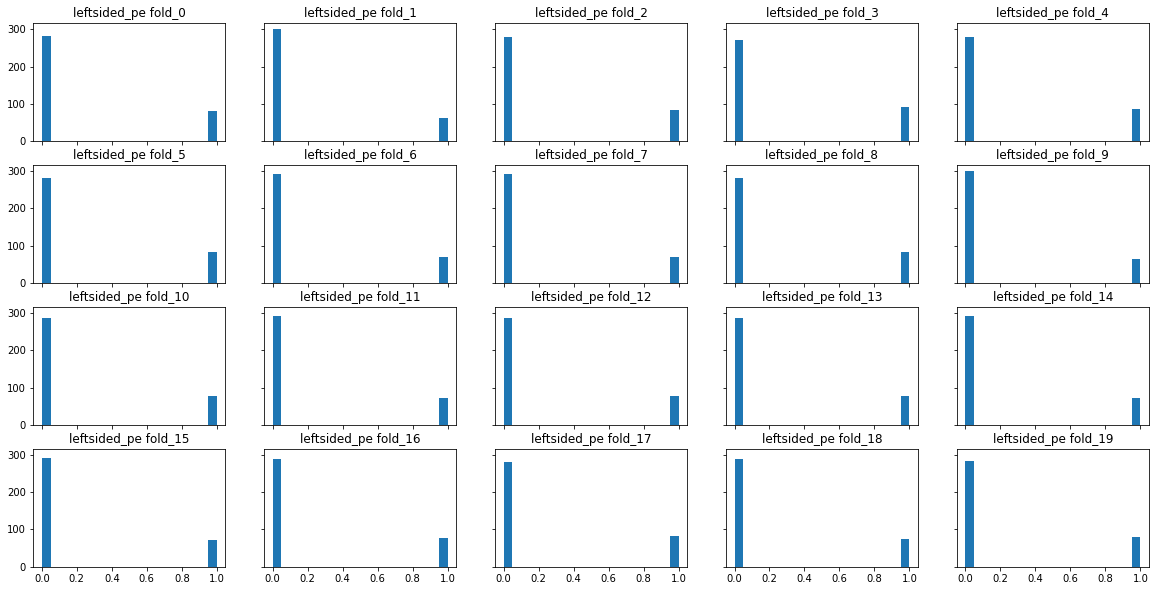

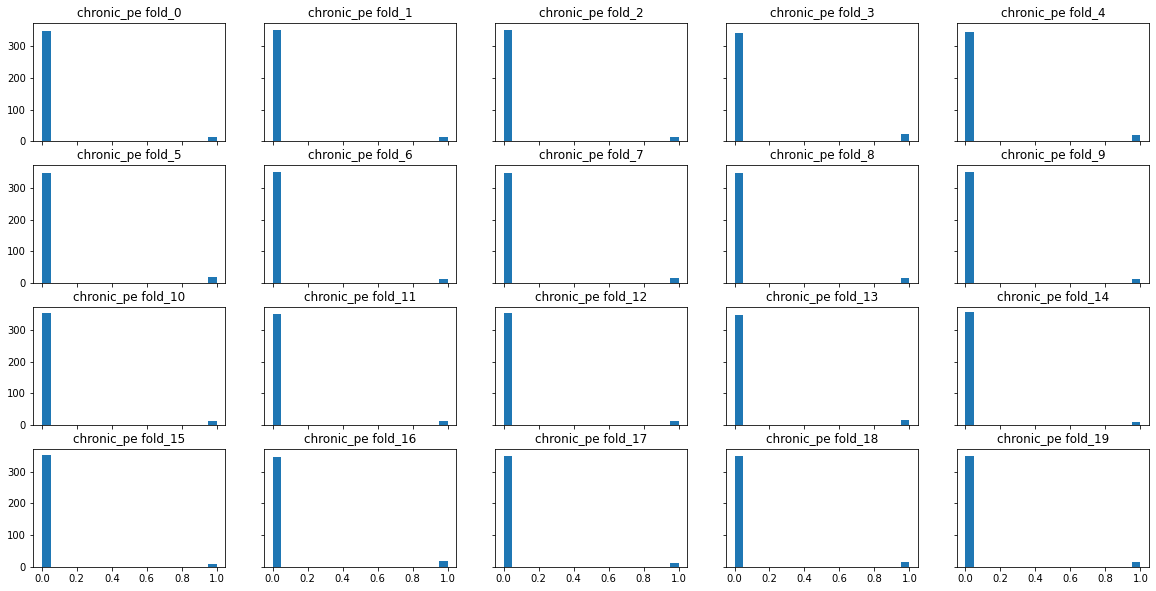

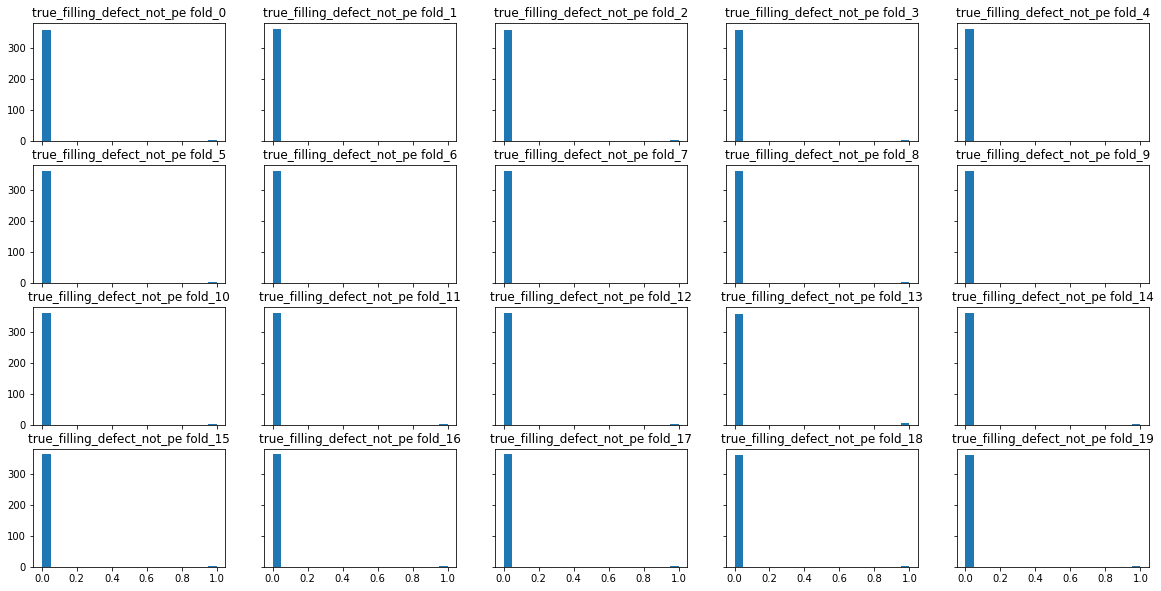

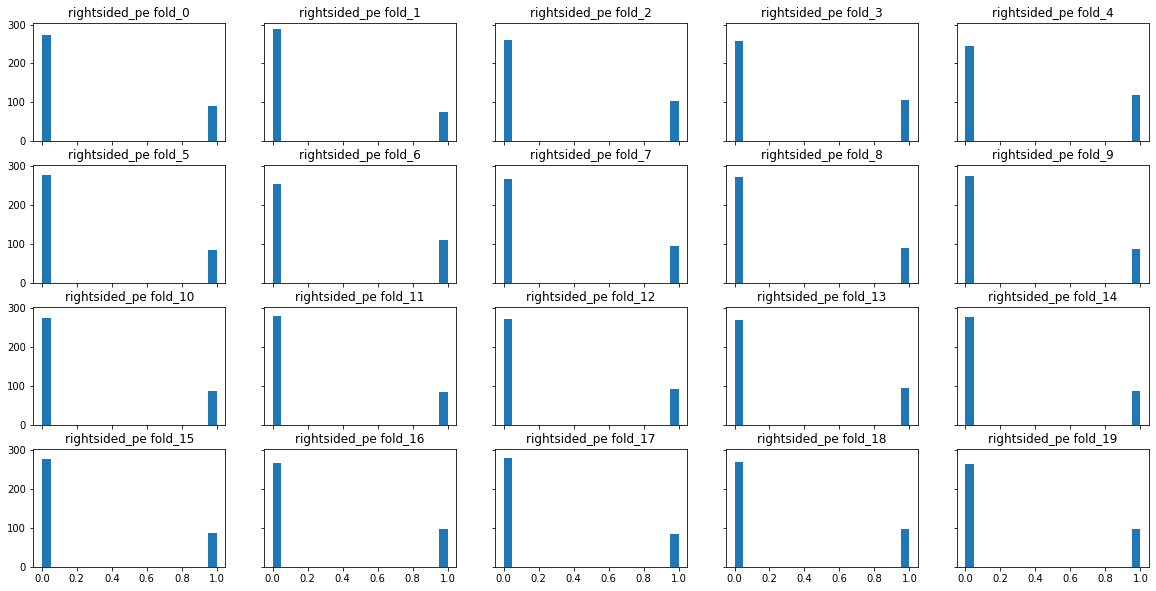

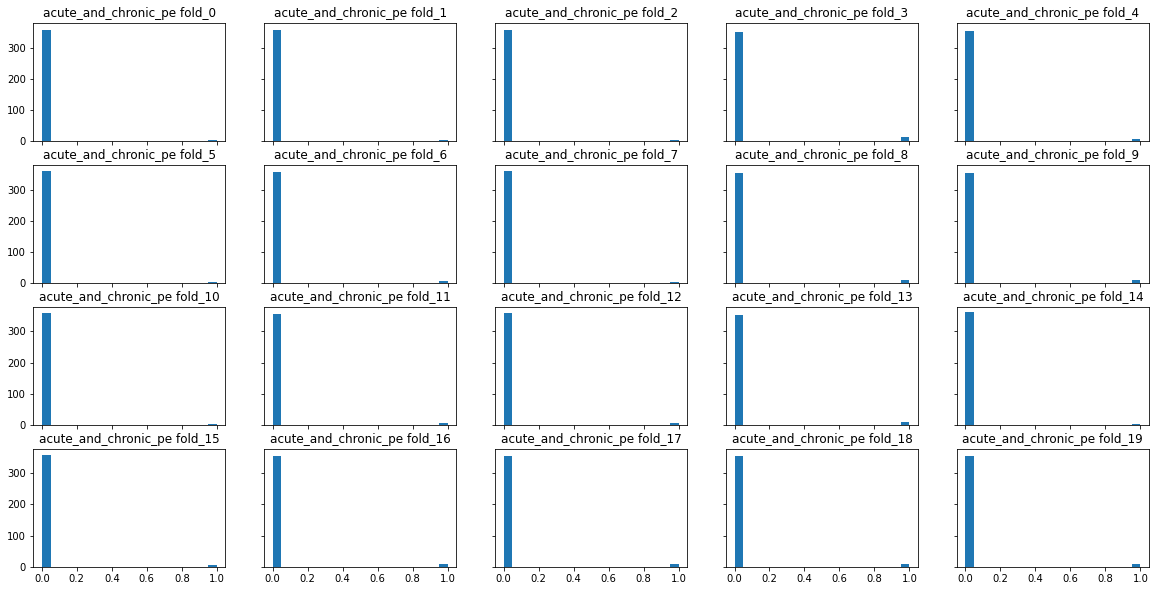

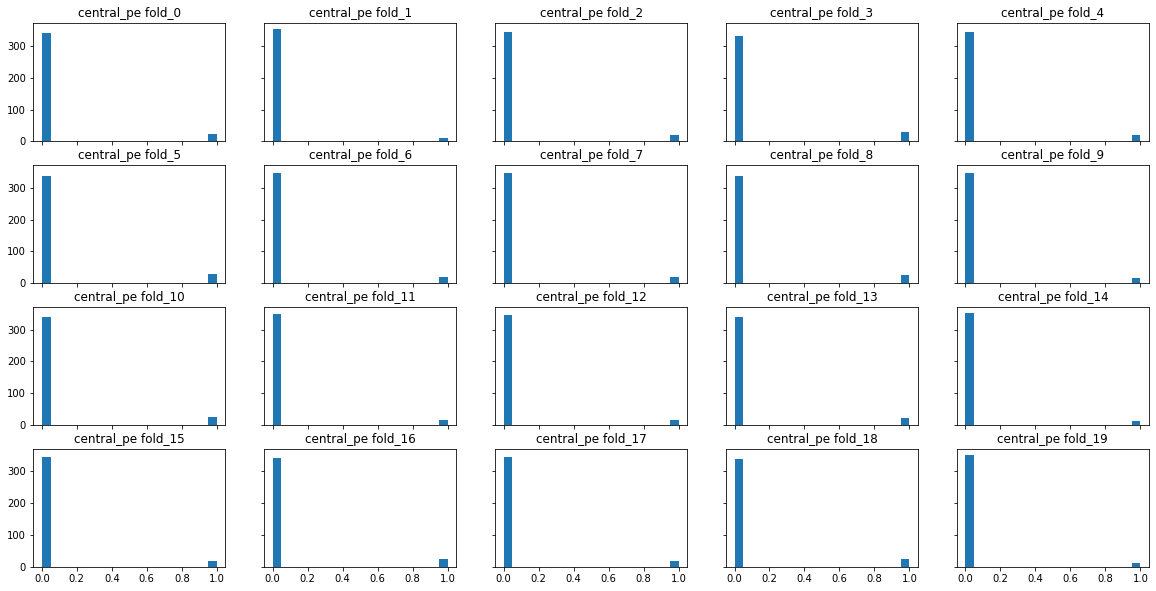

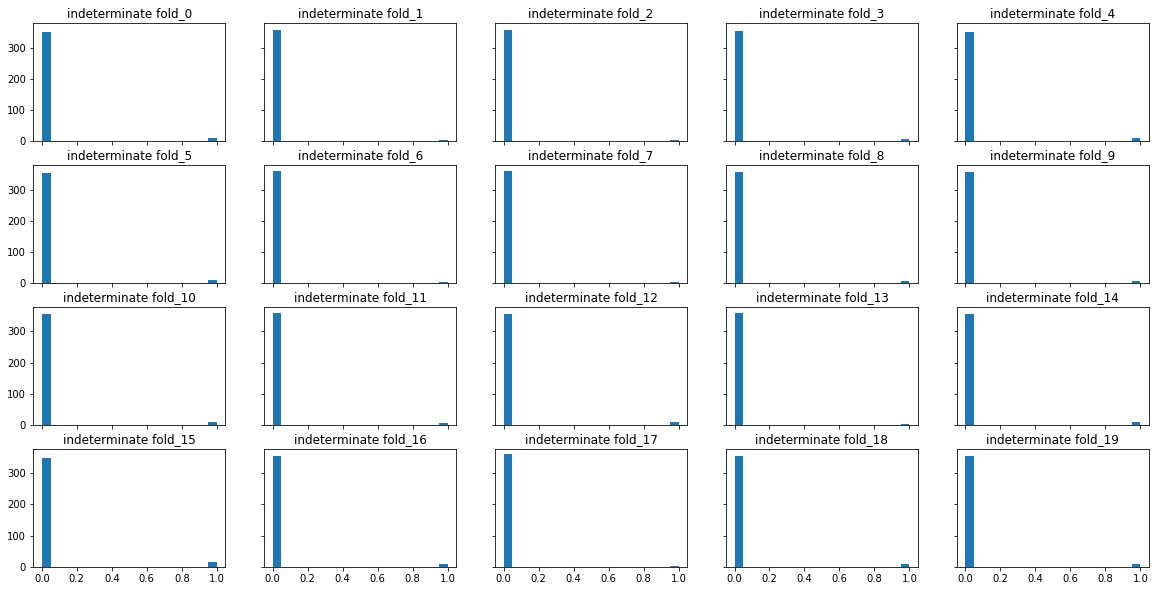

In [17]:
# check each fold for the target distribution
for col in non_digitize_cols:
    fig, axs = plt.subplots(nrows=4, ncols=int(np.floor(folds/4)), constrained_layout=False, sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    axs = axs.flat
    for i, vi in enumerate(val_indices):
        patients = train_per_patient_char.index[vi]
        axs[i].set_title(col+' fold_'+str(i))
        axs[i].hist(train_per_patient_char.loc[patients, col], bins=20, range=(train_per_patient_char[col].min(), train_per_patient_char[col].max()))
    plt.show()

# Each fold looks similar in the distribution of the number of images per patient now

In [18]:
train_per_patient_char.to_csv('/home/vishy/Desktop/Myfiles/Kaggle/RSNA_PE/inputs/rsna_train_splits_fold_{}.csv'.format(FOLD_NUM))

In [20]:
#You could use the output csv directly to do patient level subsampling (ex. select fold=1-5 to do 5 fold cross-validation)
#You could modify FOLD_NUM above to create different number of stratified folds yourself
#You could modify bin_counts+digitize_cols above to digitize columns with designated bin counts, which will be futher incorporated into the new "key" to #do the stratified validation splits